# Skin Cancer Detector

- **Objective**: To classify skin cancer using the MobileNet pre-trained model and deploying the model to a Web Application using TFjs and GitHub pages server.

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print ('Library loaded')

Library loaded


In [2]:
inp = '../input/skin-cancer-mnist-ham10000/'
os.listdir(inp)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators.

In [3]:
folders_to_create = ["HAM10000_224new"]


def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' sudah dibuat.")
        else:
            print(f"Folder '{folder}' sudah ada.")


create_folders(folders_to_create)

Folder 'HAM10000_224new' sudah dibuat.


### Create Train and Val Sets

In [4]:
base = 'HAM10000_224new'

data_pd = pd.read_csv(inp+'HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [8]:
#Memeriksa apakah terdapat gambar yang memiliki duplikat
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [9]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [10]:
#Melihat gambar-gambar yang terduplikat
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis


In [11]:
#Total gambar perkelas
class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion_type, dtype: int64


In [12]:
#Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])

In [13]:
#Memeriksa tiap gambar masuk kedalam jenis train atau test
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#membuat train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis,train


In [14]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4378,HAM_0005422,ISIC_0030554,nv,follow_up,65.0,female,lower extremity,no
7581,HAM_0000165,ISIC_0033833,nv,histo,50.0,female,foot,no
4409,HAM_0005373,ISIC_0030718,nv,follow_up,45.0,female,trunk,no
3807,HAM_0006950,ISIC_0027215,nv,follow_up,60.0,male,lower extremity,no
6268,HAM_0000929,ISIC_0029727,nv,follow_up,40.0,female,trunk,no


In [15]:
#membagi kelas
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Total data untuk train dan test
print(len(train_list))
print(len(test_list))

8912
1103


In [16]:
data_pd.set_index('image_id', inplace=True)

In [17]:
#membuat berkas train
os.mkdir(train_dir)
os.mkdir(test_dir)

In [18]:
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

folder_1 = os.listdir(inp+'ham10000_images_part_1')
folder_2 = os.listdir(inp+'ham10000_images_part_2')

# memasukkan gambar ke train set
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

#  memasukkan gambar ke test set
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# menghitung total gambar tiap kelas train set
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
Melanocytic nevi        5822
Melanoma                1067
Benign keratosis        1011
Basal cell carcinoma     479
Actinic keratoses        297
Vascular lesions         129
Dermatofibroma           107
Name: lesion_type, dtype: int64


In [19]:
#augmentasi gambar
classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 6000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [20]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
mel: 5885 images
bcc: 5798 images
bkl: 5855 images
akiec: 5990 images
nv: 6022 images
df: 4330 images
vasc: 5210 images


In [21]:
# melihat banyaknya total gambar tiap kelas
test_class_counts = test_df["dx"].value_counts()
print("Banyak gambar per kelas pada test_df:")
print(test_class_counts)

Banyak gambar per kelas pada test_df:
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64


### Training Model

In [22]:
train_path = '/kaggle/working/HAM10000_224new/train_dir'
test_path = '/kaggle/working/HAM10000_224new/test_dir'

batch_size = 32

image_size = 224

In [23]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)


Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [27]:
from vit_keras import vit

base_vitb16 = vit.vit_b16(
    image_size=(image_size, image_size),
    activation="softmax",
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=7,
)

for layer in base_vitb16.layers:
    layer.trainable = False


347512832/347502902 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


In [58]:
#ViT
model = Sequential()
model.add(base_vitb16)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(7, activation="softmax"))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 768)               3072      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               393728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)              

In [60]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [61]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

checkpoint = ModelCheckpoint(
    filepath="vitb16_2.hdf5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

In [62]:
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=40,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/40
278/278 [==============================] - 103s 328ms/step - loss: 0.9899 - acc: 0.6428 - val_loss: 0.4261 - val_acc: 0.8566

Epoch 00001: val_acc improved from -inf to 0.85662, saving model to vitb16_2.hdf5
Epoch 2/40
278/278 [==============================] - 89s 318ms/step - loss: 0.7037 - acc: 0.7376 - val_loss: 0.4165 - val_acc: 0.8612

Epoch 00002: val_acc improved from 0.85662 to 0.86121, saving model to vitb16_2.hdf5
Epoch 3/40
278/278 [==============================] - 89s 319ms/step - loss: 0.6338 - acc: 0.7615 - val_loss: 0.3335 - val_acc: 0.8824

Epoch 00003: val_acc improved from 0.86121 to 0.88235, saving model to vitb16_2.hdf5
Epoch 4/40
278/278 [==============================] - 89s 318ms/step - loss: 0.5730 - acc: 0.7869 - val_loss: 0.3523 - val_acc: 0.8704

Epoch 00004: val_acc did not improve from 0.88235
Epoch 5/40
278/278 [==============================] - 89s 319ms/step - loss: 0.5510 - acc: 0.7937 - val_loss: 0.3184 - val_acc: 0.8860

Epoch 00005: val_

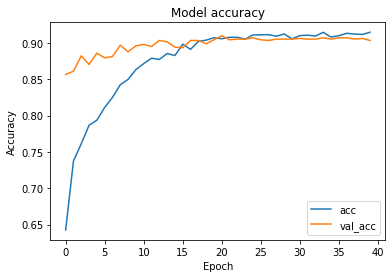

In [63]:
# plot grafik akurasi
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")  # Mengubah posisi legend
plt.show()

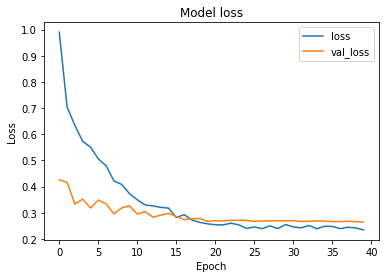

In [64]:
# plot grafik loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")
plt.show()

In [65]:
# model.save("VGG16.hdf5")
model.save("vitb16_2.hdf5")

In [66]:
train_score = model.evaluate(train_batches, verbose=1)
test_score = model.evaluate(test_batches, verbose=1)

print("Train loss: ", train_score[0])
print("Train acc: ", train_score[1])
print("-" * 75)
print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 11s 304ms/step - loss: 0.2676 - acc: 0.9030
Train loss:  0.14967194199562073
Train acc:  0.9469173550605774
---------------------------------------------------------------------------
Test loss:  0.26761186122894287
Test acc:  0.9029918313026428


In [67]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


34/34 [==============================] - 13s 309ms/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.63636   0.46667   0.53846        30
         bcc    0.67568   0.71429   0.69444        35
         bkl    0.81250   0.59091   0.68421        88
          df    0.62500   0.62500   0.62500         8
         mel    0.48649   0.39130   0.43373        46
          nv    0.94264   0.98641   0.96403       883
        vasc    1.00000   0.84615   0.91667        13

    accuracy                        0.90299      1103
   macro avg    0.73981   0.66010   0.69379      1103
weighted avg    0.89480   0.90299   0.89644      1103



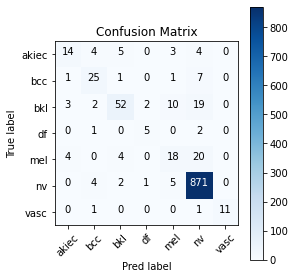

In [68]:
true_labels = test_batches.classes
model.load_weights("vitb16_2.hdf5")

#model.load_weights("VGG16.hdf5")
predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

# # We need these to plot the confusion matrix.
# test_labels

In [69]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

# # Print the label associated with each class
# test_batches.class_indices

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Found 39090 images belonging to 7 classes.
1222/1222 [==============================] - 319s 261ms/step

Training Classification Report:
               precision    recall  f1-score   support

       akiec    0.95270   0.96511   0.95887      5990
         bcc    0.97950   0.97258   0.97603      5798
         bkl    0.93493   0.84167   0.88585      5855
          df    0.99061   0.99885   0.99471      4330
         mel    0.87795   0.91062   0.89399      5885
          nv    0.91548   0.95865   0.93657      6022
        vasc    0.99847   1.00000   0.99923      5210

    accuracy                        0.94692     39090
   macro avg    0.94995   0.94964   0.94932     39090
weighted avg    0.94732   0.94692   0.94662     39090



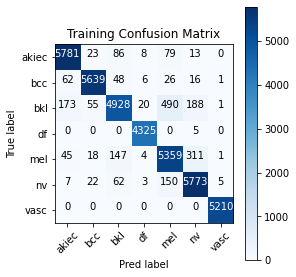

In [70]:
# Create a generator for the entire training set
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

# Calculate the number of steps needed to cover the entire training set
num_train_steps = len(train_all_batches)

# Predict labels for the entire training set
train_predictions = model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

# Compute and print the classification report and confusion matrix
train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
# print("\nTraining Confusion Matrix:\n", train_conf_matrix)

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()
# # make a prediction
# predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)